In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

# Disable warnings
import warnings
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv('df_clean.csv')

In [3]:
df.head()

,created_at,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift_dashers,total_busy_dashers,total_outstanding_orders,estimated_order_place_duration,...,store_primary_category_spanish,store_primary_category_steak,store_primary_category_sushi,store_primary_category_tapas,store_primary_category_thai,store_primary_category_turkish,store_primary_category_vegan,store_primary_category_vegetarian,store_primary_category_vietnamese,Target Variable
0,2015-02-06 22:24:17,4,3441,4,557,1239,33.0,14.0,21.0,446,...,False,False,False,False,False,False,False,False,False,3779.0
1,2015-02-10 21:49:25,1,1900,1,1400,1400,1.0,2.0,2.0,446,...,False,False,False,False,False,False,False,False,False,4024.0
2,2015-01-22 20:39:28,1,1900,1,1900,1900,1.0,0.0,0.0,446,...,False,False,False,False,False,False,False,False,False,1781.0
3,2015-02-03 21:21:45,6,6900,5,600,1800,1.0,1.0,2.0,446,...,False,False,False,False,False,False,False,False,False,3075.0
4,2015-02-15 02:40:36,3,3900,3,1100,1600,6.0,6.0,9.0,446,...,False,False,False,False,False,False,False,False,False,2390.0


In [4]:
df['created_at'] = pd.to_datetime(df['created_at'])

In [5]:
# Drop 'created_at' as it's not needed for modeling (or extract features if necessary)
X = df.drop(['Target Variable', 'created_at'], axis=1)
y = df['Target Variable']

In [6]:
# Ensure all boolean columns are converted to integers (True/False to 1/0)
X = X.applymap(lambda x: 1 if x == True else (0 if x == False else x))

In [7]:
from sklearn.preprocessing import StandardScaler

In [8]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [9]:
# Convert the DataFrame to a NumPy array
X_array = X.values

In [10]:
from sklearn.mixture import GaussianMixture

In [ ]:
# Step 1.5: Scale the Data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [12]:
# Step 2: Outlier Detection using Gaussian Mixture Models (GMM)

# Fit a GMM with one component to model the main distribution
gmm = GaussianMixture(n_components=1, covariance_type='full', random_state=42)
# gmm.fit(X_array)
gmm.fit(X_scaled)

GaussianMixture(random_state=42)

In [30]:
# Compute the log-likelihood of each sample
log_likelihood = gmm.score_samples(X)

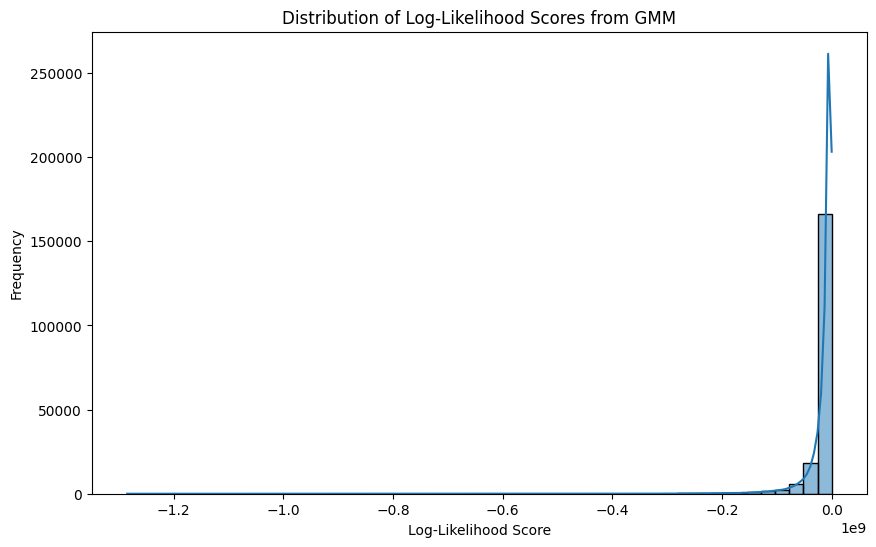

In [31]:
# Visualize the distribution of log-likelihood scores
plt.figure(figsize=(10, 6))
sns.histplot(log_likelihood, bins=50, kde=True)
plt.title('Distribution of Log-Likelihood Scores from GMM')
plt.xlabel('Log-Likelihood Score')
plt.ylabel('Frequency')
plt.show()

In [32]:
# Set a threshold to identify outliers (e.g., lower 1% quantile)
threshold = np.quantile(log_likelihood, 0.01)

In [33]:
# Identify outliers
outliers = log_likelihood < threshold

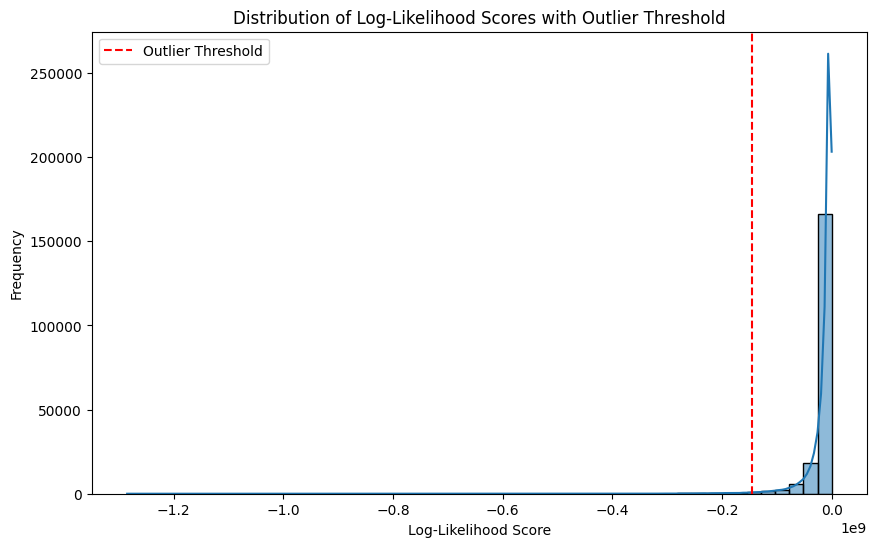

In [34]:
# Visualize the threshold on the histogram
plt.figure(figsize=(10, 6))
sns.histplot(log_likelihood, bins=50, kde=True)
plt.axvline(threshold, color='red', linestyle='--', label='Outlier Threshold')
plt.title('Distribution of Log-Likelihood Scores with Outlier Threshold')
plt.xlabel('Log-Likelihood Score')
plt.ylabel('Frequency')
plt.legend()
plt.show()

In [35]:
# Remove outliers from the dataset
X_clean = X_array[~outliers]
y_clean = y.values[~outliers]

In [36]:
# Optional: Print the number of outliers detected
print(f"Number of outliers detected: {np.sum(outliers)}")

Number of outliers detected: 1969


In [20]:
from sklearn.decomposition import PCA

In [21]:
pca = PCA(svd_solver='randomized', random_state=42)

In [22]:
pca.fit(X_clean)

PCA(random_state=42, svd_solver='randomized')

In [23]:
var_ratio={}
for n in range(1,10):
    pca=PCA(n_components=n)
    pca_components = pca.fit(X_clean)
    var_ratio[n]=sum(pca.explained_variance_ratio_)

In [24]:
var_ratio

{1: 0.8317329633835743,
 2: 0.9529697183697614,
 3: 0.9811377810862013,
 4: 0.9960462075925791,
 5: 0.9986444954813943,
 6: 0.9999246266572305,
 7: 0.9999607723421841,
 8: 0.9999807868223509,
 9: 0.9999977923756487}

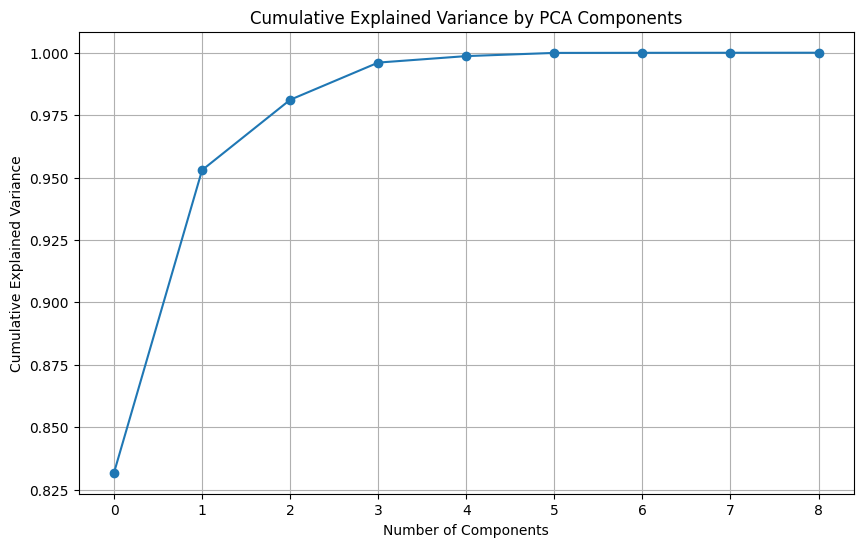

In [25]:
plt.figure(figsize=(10, 6))
plt.plot(np.cumsum(pca.explained_variance_ratio_), marker='o')
plt.title('Cumulative Explained Variance by PCA Components')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.grid(True)
plt.show()

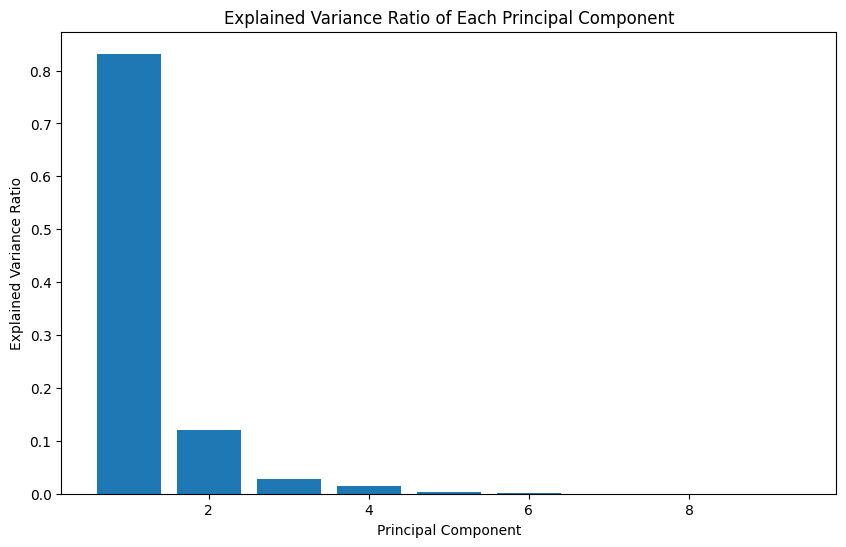

In [26]:
# Scree plot of individual explained variance
plt.figure(figsize=(10, 6))
plt.bar(range(1, len(pca.explained_variance_ratio_)+1), pca.explained_variance_ratio_)
plt.title('Explained Variance Ratio of Each Principal Component')
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.show()

In [27]:
final = PCA(n_components=3).fit(X_clean)
reduced_dim=final.fit_transform(X_clean)
# store it in a new data frame
new_data= pd.DataFrame(data = reduced_dim, columns = ['principal component 1', 'principal component 2',
                                                        'principal component 3'])

new_data.head()

,principal component 1,principal component 2,principal component 3
0,842.326790,-168.751800,41.598702
1,-613.959562,804.737051,-173.316053
2,-502.589251,1500.203512,-111.510734
3,4340.969613,-291.595638,-17.852814
4,1377.033611,406.593081,-92.038120


In [28]:
# Optional: Print the shape of the data after PCA
print(f"Original number of features: {X_clean.shape[1]}")
print(f"Reduced number of features after PCA: {new_data.shape[1]}")

Original number of features: 105
Reduced number of features after PCA: 3


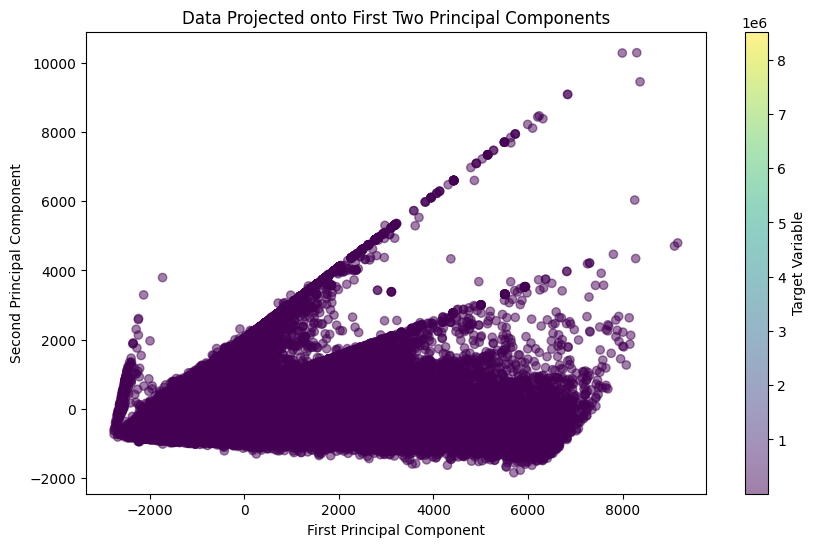

In [29]:
# Visualize the first two principal components
plt.figure(figsize=(10, 6))
plt.scatter(reduced_dim[:, 0], reduced_dim[:, 1], c=y_clean, cmap='viridis', alpha=0.5)
plt.title('Data Projected onto First Two Principal Components')
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.colorbar(label='Target Variable')
plt.show()